In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
import time

In [2]:
train_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-train.data'
test_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-test.data'

In [3]:
trainset = pd.read_table(train_path,header=None, sep='\s+')
testset = pd.read_table(test_path,header=None, sep='\s+')

In [4]:
trainset.shape

(3772, 22)

In [5]:
var_names = ["V"+str(i) for i in range(trainset.shape[1])]
var_names

['V0',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21']

In [6]:
trainset.columns = var_names
testset.columns = var_names

In [7]:
trainset.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0.00060,0.015,0.120,0.082,0.146,3
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.030,0.143,0.133,0.108,3
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00190,0.024,0.102,0.131,0.078,3
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00090,0.017,0.077,0.090,0.085,3
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.026,0.139,0.090,0.153,3


In [8]:
trainset["V21"].value_counts()

3    3488
2     191
1      93
Name: V21, dtype: int64

In [9]:
trainset.describe()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
count,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,...,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000
mean,0.515102,0.303022,0.123277,0.012990,0.011400,0.038441,0.014051,0.014316,0.015111,0.062036,...,0.008749,0.025186,0.000265,0.049311,0.004761,0.020191,0.108286,0.099288,0.110154,2.900053
std,0.189525,0.459626,0.328798,0.113248,0.106174,0.192284,0.117716,0.118806,0.122012,0.241253,...,0.093137,0.156709,0.016282,0.216545,0.023308,0.007421,0.034488,0.018612,0.033493,0.373236
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000500,0.002000,0.019000,0.002000,1.000000
25%,0.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000600,0.017000,0.089000,0.089000,0.093000,3.000000
50%,0.540000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001600,0.020600,0.105500,0.099000,0.108000,3.000000
75%,0.670000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002400,0.023000,0.123000,0.107000,0.122000,3.000000
max,0.940000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.530000,0.105900,0.430000,0.232000,0.612000,3.000000


<AxesSubplot:>

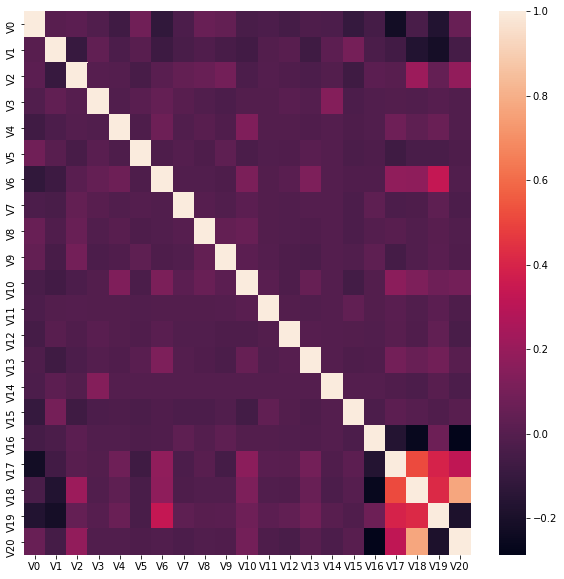

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(data=trainset.drop('V21', axis=1).corr())

In [11]:
# Base classifiers for the ensemble methods
nb = GaussianNB()
knn = KNeighborsClassifier(p=1, n_neighbors=1)
tree = DecisionTreeClassifier(max_depth=2)
tree

DecisionTreeClassifier(max_depth=2)

In [18]:
import multiprocessing
n_jobs = multiprocessing.cpu_count()
print(n_jobs)

4


In [19]:
# Bagg_nb = BaggingClassifier(base_estimator=nb, n_estimators=50, n_jobs=10, random_state=1234)
# Bagg_tree = BaggingClassifier(base_estimator=tree, n_estimators=50, n_jobs=10, random_state=1234)
# Bagg_knn = BaggingClassifier(base_estimator=knn, n_estimators=50, n_jobs=10, random_state=1234)

Bagg_nb = BaggingClassifier(base_estimator=nb, n_estimators=50, n_jobs=4, random_state=1234)
Bagg_tree = BaggingClassifier(base_estimator=tree, n_estimators=50, n_jobs=-1, random_state=1234)
Bagg_knn = BaggingClassifier(base_estimator=knn, n_estimators=50, n_jobs=4, random_state=1234)
Bagg_tree

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                  n_estimators=50, n_jobs=-1, random_state=1234)

In [20]:
# dividing trainset in 70:30 ratio
x_train, x_test, y_train, y_test = train_test_split(trainset.iloc[:,:21], trainset['V21'], 
                                                    test_size=0.3, random_state=1234)

In [21]:
x_train.shape, y_train.shape

((2640, 21), (2640,))

In [22]:
%%timeit

Bagg_nb.fit(X=x_train, y=y_train)

98.1 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
pred_bagg_nb = Bagg_nb.predict(x_test)

In [24]:
confusion_matrix(y_test, pred_bagg_nb)

array([[ 26,   1,   1],
       [ 41,  10,   0],
       [791, 212,  50]], dtype=int64)

In [25]:
%%timeit

Bagg_knn.fit(X=x_train, y=y_train)
pred_bagg_knn = Bagg_knn.predict(x_test)
print(confusion_matrix(y_test, pred_bagg_knn))

[[  17    5    6]
 [   0   11   40]
 [   3   22 1028]]
[[  17    5    6]
 [   0   11   40]
 [   3   22 1028]]
[[  17    5    6]
 [   0   11   40]
 [   3   22 1028]]
[[  17    5    6]
 [   0   11   40]
 [   3   22 1028]]
[[  17    5    6]
 [   0   11   40]
 [   3   22 1028]]
[[  17    5    6]
 [   0   11   40]
 [   3   22 1028]]
[[  17    5    6]
 [   0   11   40]
 [   3   22 1028]]
[[  17    5    6]
 [   0   11   40]
 [   3   22 1028]]
2.24 s ± 159 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%%timeit

Bagg_tree.fit(X=x_train, y=y_train)
pred_bagg_tree = Bagg_tree.predict(x_test)
print(confusion_matrix(y_test, pred_bagg_tree))

[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    0    0]
 [   0   51    0]
 [   4   20 1029]]
[[  28    

In [27]:
# testing model on test data
pred_tree_bag = Bagg_tree.predict(testset.iloc[:,:21])
confusion_matrix(testset['V21'], pred_tree_bag)

array([[  73,    0,    0],
       [   0,  177,    0],
       [  11,   87, 3080]], dtype=int64)

In [30]:
boost_nb = AdaBoostClassifier(base_estimator=nb, n_estimators=150, random_state=1234)
boost_tree = AdaBoostClassifier(base_estimator=tree, n_estimators=150, random_state=1234)

In [31]:
boost_nb.fit(x_train, y_train)
confusion_matrix(y_test, boost_nb.predict(x_test))

array([[ 21,   5,   2],
       [  1,  30,  20],
       [ 17, 142, 894]], dtype=int64)

In [32]:
boost_tree.fit(x_train, y_train)
confusion_matrix(y_test, boost_tree.predict(x_test))

array([[  28,    0,    0],
       [   0,   50,    1],
       [   4,    1, 1048]], dtype=int64)

In [33]:
# testing model on test data
confusion_matrix(testset['V21'], boost_tree.predict(testset.iloc[:,:21]))

array([[  70,    0,    3],
       [   0,  176,    1],
       [  11,   10, 3157]], dtype=int64)

In [46]:
rf = RandomForestClassifier(max_depth=10, max_features=6, n_jobs=4, random_state=1234)
gbm = GradientBoostingClassifier()
# xgb = XGBClassifier(n_estimators=100, n_jobs=-1)
xgb = XGBClassifier(n_estimators=100, n_jobs=-1, num_parallel_tree=1)

In [47]:
rf.fit(x_train, y_train)
gbm.fit(x_train, y_train)
xgb.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:21:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [48]:
print(confusion_matrix(testset['V21'], rf.predict(testset.iloc[:,:21])))
print(confusion_matrix(testset['V21'], gbm.predict(testset.iloc[:,:21])))
print(confusion_matrix(testset['V21'], xgb.predict(testset.iloc[:,:21])))

[[  70    2    1]
 [   0  177    0]
 [  11   16 3151]]
[[  66    4    3]
 [   0  177    0]
 [  11   13 3154]]
[[  72    0    1]
 [   0  176    1]
 [  11   11 3156]]


In [49]:
pca = PCA(n_components=2)
pca.fit(trainset.iloc[:,:21])

PCA(n_components=2)

In [50]:
pca_mat = pca.transform(trainset.iloc[:,:21])

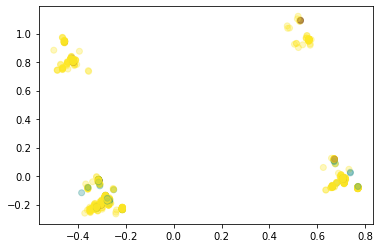

In [51]:
plt.scatter(pca_mat[:,0], pca_mat[:,1], c=trainset['V21'], alpha=0.3)
plt.show()

In [52]:
svd = TruncatedSVD(n_components=2)

In [53]:
svd_mat = svd.fit_transform(trainset.iloc[:,:21])

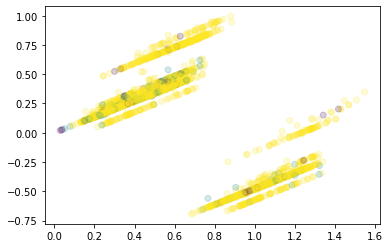

In [54]:
plt.scatter(svd_mat[:,0], svd_mat[:,1], c=trainset['V21'], alpha=0.2)
plt.show()